In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_pred = os.path.join(pth_data, 'modeling', 'predict')
pth_out = os.path.join(pth, 'figures', 'modeling', 'embeddings')

In [3]:
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
df

,Name,Study,Species,Trajectory,Age,Description
Source,,,,,,
GSE136689,Splanchnic Mesoderm,"Han et al., 2020",mmusculus,True,E8.5-9.5,Foregut organogenesis dataset showing interact...
GSE162534,Primitive Streak,"Scheibner et al., 2021",mmusculus,True,Early-Late Streak,Gastrulation dataset analyzing EMT programs du...
GSE201257,Schwann Cell Precursor,"Kastriti et al, 2022",mmusculus,True,E9.5-Adult,Neural crest cell atlas describing diversifica...
GSE229103,Neuromesodermal Progenitor,"Jin et al., 2025",mmusculus,True,E8.5,Developmental dataset describing bipotent neur...
HCAEmbryonicHindlimb,Embryonic Hindlimb,"Zhang et al., 2024",hsapiens,True,PCW5-9,Embryonic hindlimb atlas focusing on spatial a...
rRNAModifications,Cranial Neural Crest,Poverennaya et al.,mmusculus,True,E8.5-10.5,Neural crest cell dataset showing the bifurcat...
CCCA,Curated Cancer Cell Atlas,"Tyler et al., 2025",hsapiens,False,Primary & Metastatic,Cancer atlas containing 70+ curated single-cel...
EMTHallmark,EMT Hallmark,"Liberzon et al., 2015",hsapiens,False,NaN,Genes defining epithelial-mesenchymal transiti...
TCGA,The Cancer Genome Atlas,"TCGA Network, 2013",hsapiens,False,Primary & Metastatic,The Cancer Genome Atlas dataset of >40 cancer ...


In [4]:
adata = sc.read_h5ad(os.path.join(pth_pred, 'training.h5ad'))
adata

AnnData object with n_obs × n_vars = 1573925 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 'training', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score'

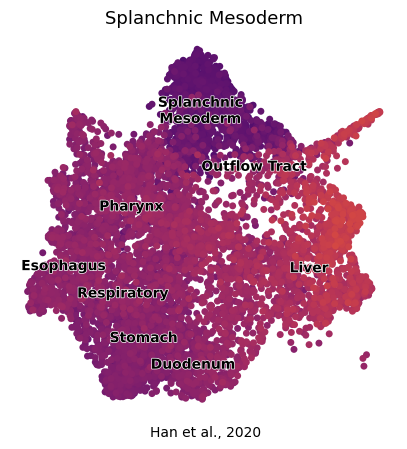

In [30]:
geo = 'GSE136689'
adata_plt = adata[adata.obs.source == geo].copy()

vmin, vmax, cmap =  0, 1.5, 'inferno'
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.embedding(adata_plt, 'X_draw_graph_fa', color = 'latent_z',
                size = 100, cmap = cmap, vmin = vmin, vmax = vmax,
                frameon = False, show = False, ax = ax, colorbar_loc = None)
sc.pl.embedding(adata_plt, 'X_draw_graph_fa', color = 'celltype',
                alpha = 0, size = 100, legend_loc = 'on data',
                na_in_legend = False, legend_fontoutline = 1,
                frameon = False, show = False, ax = ax)

label_dict = {'Splanchnic Mesoderm' : 'Splanchnic\nMesoderm'}
pos_dict = {'Splanchnic Mesoderm' : (0, 300),
            'Outflow Tract'       : (1000, -200),
            'Respiratory'         : (0, -300)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

ax.set_title(df.loc[geo].Name, size = 13)
ax.text(.36, -.05, df.loc[geo].Study, transform = ax.transAxes)
fn = os.path.join(pth_out, f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')

In [ ]:
# plot developmental celltypes
fig, ax = plt.subplots(1, 1, figsize = (4.5, 10.25))
dev = (adata.obs.celltype != 'Malignant')
df_plt = adata[dev].obs.copy()
df_plt['hue'] = df_plt.source.map(name_dict)
ix = (df_plt.groupby('category')
      .agg({'latent_z' : 'mean',
            'hue'      : 'first'})
      .sort_values(['hue', 'latent_z']).index)
sns.boxplot(df_plt,
            x = 'latent_z',
            y = 'category',
            hue = 'hue',
            dodge = False,
            order = ix,
            showfliers = False,
            palette = 'Dark2',
            ax = ax)
leg = ax.legend(bbox_to_anchor = (1, 1),
    fontsize = 8.5,
                edgecolor = 'gray')
ax.set_xlabel('MesenCoder Score')
ax.set_ylabel('')
ax.set_title('Developmental')
ax.set_xlim([-.025, 1.525])
ax.set_xticks(np.arange(0, 1.51, .5).round(1))
ax.grid(axis = 'x')
# fn = os.path.join(pth_out, 'development.pdf')
# plt.savefig(fn, bbox_inches = 'tight')
ax.axvline(.4, c = 'k', ls = '--', lw = 1)
plt.show()

In [ ]:
msk = (adata.obs.source == df.index[1])
sc.pl.umap(adata[msk], color = 'latent_z', cmap = 'jet', show = False)
sc.pl.umap(adata[msk], color = 'celltype', alpha = 0, legend_loc = 'on data', legend_fontoutline = 1, ax = plt.gca())


In [ ]:
# plot malignant celltypes (3CA)
fig, ax = plt.subplots(1, 1, figsize = (4.5, 10.25))
df_plt = adata[~dev].obs.copy()
ix = (df_plt.groupby('category')
      .latent_z.median()
      .sort_values().index)
sns.boxplot(df_plt,
            x = 'latent_z',
            y = 'category',
            hue = 'Category',  # 3CA
            dodge = False,
            order = ix,
            showfliers = False,
            palette = 'rainbow',
            ax = ax)
leg = ax.legend(fontsize = 9,
                edgecolor = 'gray')
ax.set_xlabel('MesenCoder Score')
ax.set_ylabel('')
ax.set_title('Malignant')
ax.set_xlim([-.033, 2.125])
ax.set_xticks(np.arange(0, 2.1, .5).round(1))
ax.grid(axis = 'x')
fn = os.path.join(pth_out, 'malignant.pdf')
plt.savefig(fn, bbox_inches = 'tight')